# Week 3 Stats Assignment

In [2]:
import numpy as np
import scipy as sci
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

## Question 1

In [3]:
freqs = np.linspace(10, 110, 11)
voltages = np.array((16, 45, 64, 75, 70, 115, 142, 167, 183, 160, 221),
                        dtype='f') * 1e-3
errors = np.array((5, 5, 5, 5, 30, 5, 5, 5, 5, 30, 5), dtype='f') * 1e-3

*i) Calculate the 4 elements of the curvature matrix.*

From last week we know a linear fit works for this data, so we can use the analytical results for the curvature matrix.

In [4]:
A_cc = sum(1. / errors**2, 0.)
A_cm = sum(freqs / errors**2, 0.)
A_mc = A_cm
A_mm = sum(freqs**2 / errors**2, 0.)
A = np.matrix([[A_cc, A_cm], [A_mc, A_mm]])
print('Curvature matrix is:\n', A)

Curvature matrix is:
 [[  3.62222187e+05   2.05666642e+07]
 [  2.05666642e+07   1.53788870e+09]]


*ii) Invert this to give the error matrix.*

Inverting $A$ gives the error matrix $C$.

In [5]:
C = A.I
print('Error matrix is:\n', C)

Error matrix is:
 [[  1.14708120e-05  -1.53402738e-07]
 [ -1.53402738e-07   2.70174466e-09]]


*iii) What are the uncertainties in the slope and intercept?*

To get the uncertainties in $m$ and $c$, we take the square root of the diagonal terms of $C$.

In [6]:
alphas = np.sqrt(C.diagonal())

print('Uncertainty in m is: {:.1g} mV/Hz'.format(alphas[0,1]*1e3))
print('Uncertainty in c is: {:.1g} mV'.format(alphas[0,0]*1e3))

Uncertainty in m is: 0.05 mV/Hz
Uncertainty in c is: 3 mV


*iv) Comment on your answer.*

These values are identical to those otained last week from doing a weighted least-squares fit.

## Question 2

Done on separate sheet.

## Question 3

In [7]:
concentrations = np.linspace(0.025, 0.175, 7)
thetas = np.array([10.7, 21.6, 32.4, 43.1, 53.9, 64.9, 75.4])
errors = np.full(7, 0.1)

# Straight line fit parameters
m = 431.7 # deg cm^3 / g
c = -0.03 # deg

*Show that the curvature matrix is given by...*

In [8]:
A_cc = sum(1. / errors**2, 0.)
A_cm = sum(concentrations / errors**2, 0.)
A_mc = A_cm
A_mm = sum(concentrations**2/errors**2, 0.)
A = np.matrix([[A_cc, A_cm], [A_mc, A_mm]])
print('Curvature matrix is:\n', A)

Curvature matrix is:
 [[ 700.     70.  ]
 [  70.      8.75]]


*...and that the error matrix is...*

In [9]:
C = A.I
print('Error matrix is:\n', C)

Error matrix is:
 [[ 0.00714286 -0.05714286]
 [-0.05714286  0.57142857]]


*Calculate the associated correlation matrix.*

Entries are given by $\rho_{AB}=\frac{C_{AB}}{\sqrt{C_{AA} C_{BB}}}$

In [10]:
def rho_ab(a, b, cov):
    a = int(a)
    b = int(b)
    return cov[a, b] / np.sqrt(cov[a, a] * cov[b, b])

# makes this function work with np.vectorize
vrho = np.vectorize(rho_ab, excluded={'cov'})

corr = np.fromfunction(vrho, (2,2),cov=C)
corr = np.matrix(corr)

print('Correlation matrix is:\n',corr)

Correlation matrix is:
 [[ 1.         -0.89442719]
 [-0.89442719  1.        ]]


*i) What are the uncertainties in the best-fit intercept and gradient?*

As before, these are given by the square roots of the diagonal elements of $C$.

In [11]:
alphas = np.sqrt(C.diagonal())
alpha_m = alphas[0,1]
alpha_c = alphas[0,0]

print('Uncertainty in m is: {:.1g} deg cm^3 / g'.format(alpha_m))
print('Uncertainty in c is: {:.1g} deg'.format(alpha_c))

Uncertainty in m is: 0.8 deg cm^3 / g
Uncertainty in c is: 0.08 deg


*ii) What optical rotation is expected for a known concentration of $C=0.080\ \mathrm{g\ cm^{-3}}$, and what is the uncertainty?*

Fit is $\theta=mC + c$.
The nonzero correlation coefficients found above need to be taken into account to calculate the uncertainty.
The required expression (from Table 7.2 in the book) is:
$\alpha_\theta^2=C^2\alpha_m^2+\alpha_c^2+2C\alpha_{mc}$

In [12]:
conc = 0.080
expected_rotation = m * conc + c
uncertainty = np.sqrt(conc**2 * C[0,0] + C[1,1] + 2 * conc * C[0,1])

print('Result: expected rotation is ({:.3g} +- {:.1g}) deg'
      .format(expected_rotation, uncertainty))

Result: expected rotation is (34.5 +- 0.7) deg


*iii) What is the concentration given a measured rotation of $\theta=70.3^{\circ}$, and what is the uncertainty?*

Invert fit function: $C = \theta/m - c/m$. 

For the second term, from Table 7.2:
$(\alpha_C/C)^2=(\alpha_m/m)^2+(\alpha_c/c)^2-2(\alpha_{mc}/mc)$

The first term contributes an additional factor $\alpha_m/m$.

In [13]:
theta = 70.3
expected_conc = (theta - c) / m
alpha_1 = (theta / m) * (alpha_m / m)
alpha_2 = (c / m) * np.sqrt((alpha_c / c)**2 + (alpha_m / m)**2
                           - 2 * C[0, 1] / (m * c))
uncertainty = np.sqrt(alpha_1**2 + alpha_2**2)
print('Result: expected concentration is ({:.4g} +- {:.1g}) g/cm^3'
      .format(expected_conc, uncertainty))

Result: expected concentration is (0.1629 +- 0.0003) g/cm^3


## Question 4

<Container object of 3 artists>

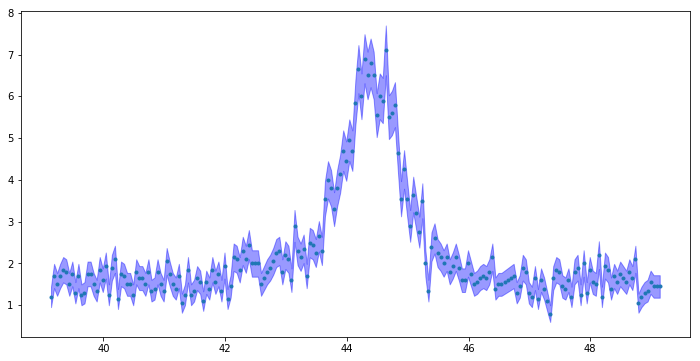

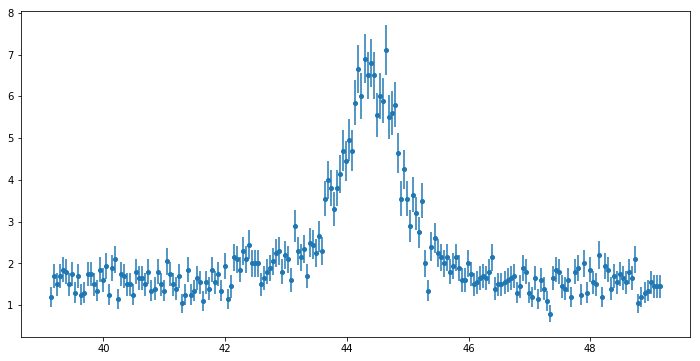

In [14]:
data = np.loadtxt('LorentzianData.csv', skiprows=3,
                 dtype = [('angle', 'f'), ('cps', 'f'), ('err', 'f')])

plt.figure(figsize=(12, 6))
plt.fill_between(data['angle'], data['cps'] + data['err'],  data['cps'] - data['err'],
                alpha=0.4, color='b')
plt.plot(data['angle'], data['cps'], 'o', ms=3)

plt.figure(figsize=(12, 6))
plt.errorbar(data['angle'], data['cps'], data['err'], fmt='o', ms=4)

*i) Explain how the error in the count rate was calculated.*

The counts measured per second should follow a Poisson distribution, for which the error in the counts is given by $\sqrt{\bar{x}}$. Since the results have been measured in 20-second bins, the count rate should first be divided by 20.

In [16]:
# tests whether the statement above is right
print(np.isclose(data['err'], np.sqrt(data['cps'] / 20)).all())

True


*ii) Perform a $\chi^2$ minimisation. What are the best-fit parameters?*

In [16]:
# The form of the fitting function
def S(theta, S_bgd, S_0, theta_0, delta_theta):
    return S_bgd + S_0 / (1 + 4 * ((theta - theta_0) / delta_theta)**2)

#  The gradient vector for the fitting function
def dS(theta, S_bgd, S_0, theta_0, delta_theta):
    dSdS_0 = 1 / (1 + 4 * ((theta - theta_0) / delta_theta)**2)
    dSdS_bgd = np.ones_like(theta) 
    dSdtheta_0 = ((8 * delta_theta **2 * S_0 * (theta - theta_0))/
                  (4 * (theta - theta_0)**2 + delta_theta**2)**2)
    dSddelta_theta = ((8 * delta_theta * S_0 * (theta - theta_0)**2)/
                      (4*(theta - theta_0)**2 + delta_theta**2)**2)
    return (dSdS_bgd,dSdS_0, dSdtheta_0, dSddelta_theta)

# Definition of chi squared
def chi2(x):
    return sum((data['cps'] - S(data['angle'], *x))**2 / data['err']**2)

# Gradient vector/Jacobian for chi squared
def dchi2(x):
    diff = dS(data['angle'], *x)
    return np.array([sum((data['cps'] - S(data['angle'], *x)) / data['err']**2
                    * -2. * diff[i]) for i in range(4)])

SciPy has the `optimize` library which can do the minimisation for us. Specifically the `minimize` function takes the (multi-variable) function to minimise and a vector of initial guesses for the parameters.

The `BFGS` solver is ideal because it also calculates (approximately) the inverse of the Hessian matrix, which we can use to obtain the error matrix.

Best-fit parameters are:
    S_bgd = 1.404403699969694
    S_0 = 5.4263184427109055
    theta_0 = 44.390120690814236
    delta_theta = 0.9498836597699426
      fun: 226.47279372137018
 hess_inv: array([[  3.84084851e-04,   8.57325408e-05,   4.60215003e-08,
         -2.96164628e-04],
       [  8.57325408e-05,   1.87964823e-02,   7.11807054e-05,
         -2.72520590e-03],
       [  4.60215003e-08,   7.11807054e-05,   1.22068597e-04,
         -1.19234860e-05],
       [ -2.96164628e-04,  -2.72520590e-03,  -1.19234860e-05,
          9.05674751e-04]])
      jac: array([ 0.00070764, -0.00019515,  0.01145638,  0.00041559])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 88
      nit: 12
     njev: 76
   status: 2
  success: False
        x: array([  1.4044037 ,   5.42631844,  44.39012069,   0.94988366])


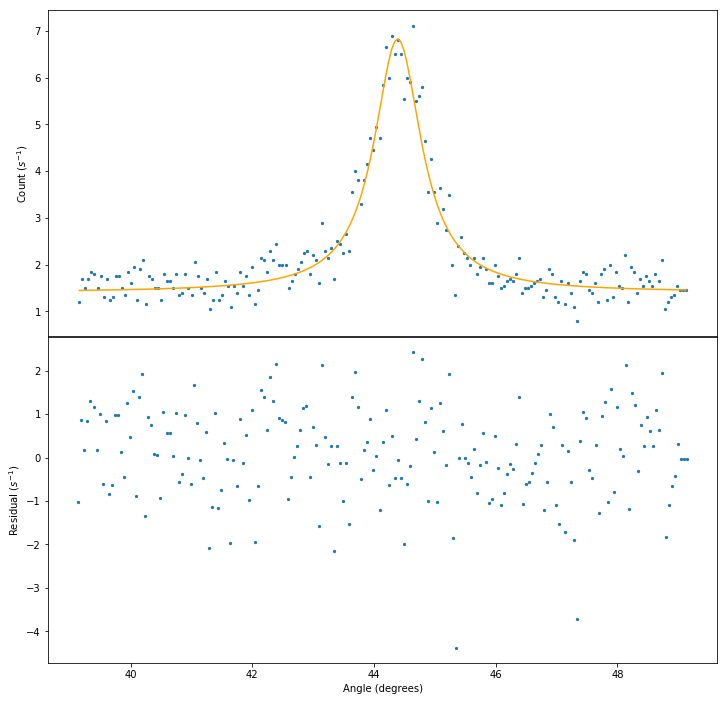

In [25]:
import scipy.optimize as optimize

# Initial guesses for the parameters
S_bgd = 1.5
S_0 = 5
theta_0 = 45
delta_theta = 1

# The initial guesses get passed in as a vector
x0 = np.array([S_bgd, S_0, theta_0, delta_theta])

res = optimize.minimize(chi2, x0, jac=dchi2, method='BFGS')
print('''Best-fit parameters are:
    S_bgd = {}
    S_0 = {}
    theta_0 = {}
    delta_theta = {}'''.format(*res.x))

print(res)

S_bgd, S_0, theta_0, delta_theta = res.x
minimised_chi2 = res.fun

xs = data['angle']
ys = S(xs, *res.x)
residuals = (data['cps'] - ys) / data['err']

plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.001)
ax1 = plt.subplot(211)
ax1.xaxis.set_visible(False)
ax1.set_ylabel('Count $(s^{-1})$')
plt.plot(xs, ys, 'orange')
plt.scatter(data['angle'], data['cps'], s=5)

ax2 = plt.subplot(212)
ax2.set_ylabel('Residual $(s^{-1})$')
ax2.set_xlabel('Angle (degrees)')
plt.scatter(data['angle'], residuals, s=5)

*iii) Evaluate the error matrix.*

Error matrix $C=A^{-1}$.  
Curvature matrix $A = 0.5H$.  
Hessain matrix $H$ is matrix of partial differentials of $\chi^2$.

In [18]:
# C = inverse(0.5 * H)
#   = inverse(H) * 2

C = 2 * res.hess_inv

print('Error matrix is:\n', C)

Error matrix is:
 [[  7.68169703e-04   1.71465082e-04   9.20430007e-08  -5.92329255e-04]
 [  1.71465082e-04   3.75929645e-02   1.42361411e-04  -5.45041180e-03]
 [  9.20430007e-08   1.42361411e-04   2.44137195e-04  -2.38469721e-05]
 [ -5.92329255e-04  -5.45041180e-03  -2.38469721e-05   1.81134950e-03]]


*iv) Calculate the correlation matrix.*

Same method as in Q3. 

In [19]:
# S_bgd       S_0 theta_0 delta_theta
# S_0
# theta_0
# delta_theta
corr = np.fromfunction(vrho, (4, 4), cov=C)
corr = np.matrix(corr)
print('Correlation matrix is:\n', corr)

Correlation matrix is:
 [[  1.00000000e+00   3.19075763e-02   2.12542217e-04  -5.02150001e-01]
 [  3.19075763e-02   1.00000000e+00   4.69917935e-02  -6.60503162e-01]
 [  2.12542217e-04   4.69917935e-02   1.00000000e+00  -3.58604009e-02]
 [ -5.02150001e-01  -6.60503162e-01  -3.58604009e-02   1.00000000e+00]]


*v) What are the uncertainties in the best-fit parameters?*

As before, this is just the square root of the diagonal of the error matrix.

In [20]:
alphas = np.sqrt(C.diagonal())
print('''Uncertainties in best-fit parameters are:
    alpha_S_bgd = {}
    alpha_S_0 = {}
    alpha_theta_0 = {}
    alpha_delta_theta = {}'''.format(*alphas))

print('''Hence results are:
    S_bgd = {:.2f} +- {:.1g}
    S_0 = {:.3g} +- {:.2g}
    theta_0 = {:.4g} +- {:.1g}
    delta_theta = {:.2g} +- {:.1g}'''.format(*itertools.chain(*zip(res.x, alphas))))

Uncertainties in best-fit parameters are:
    alpha_S_bgd = 0.02771587456322677
    alpha_S_0 = 0.1938890520891835
    alpha_theta_0 = 0.015624890238459057
    alpha_delta_theta = 0.042559951844800416
Hence results are:
    S_bgd = 1.40 +- 0.03
    S_0 = 5.43 +- 0.19
    theta_0 = 44.39 +- 0.02
    delta_theta = 0.95 +- 0.04


*vi) Make $\chi^2$ contour plots for (a) $S_{bgd}$ against $\theta_0$, (b) $S_{bgd}$ against $\Delta\theta$*

*Comment on the shape of the contours.*

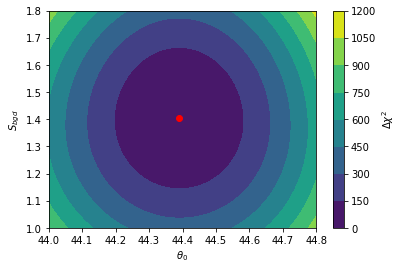

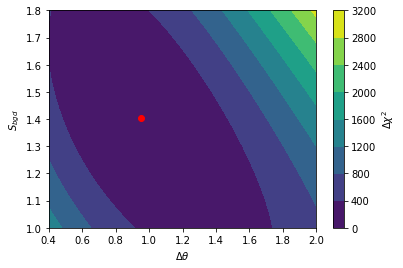

In [21]:
# S_bgd - theta_0
N = 100
rge_S_bgd = np.linspace(1.0, 1.8, N)
rge_theta_0 = np.linspace(44, 44.8, N)

chisqs = np.zeros((N, N))
for x in range(N):
        for y in range(N):
            chisqs[y, x] = chi2((rge_S_bgd[y], S_0, rge_theta_0[x], delta_theta)) - minimised_chi2

plt.figure()
ax = plt.gca()
ax.set_ylabel('$S_{bgd}$')
ax.set_xlabel(r'$\theta_0$')
plt.contourf(rge_theta_0, rge_S_bgd, chisqs)
cb = plt.colorbar()
cb.set_label('$\Delta\chi^2$')
plt.scatter(theta_0, S_bgd, c='r')

# S_bgd - delta_theta
rge_delta_theta = np.linspace(0.4, 2.0, N)

chisqs = np.zeros((N, N))
for x in range(N):
        for y in range(N):
            chisqs[y, x] = chi2((rge_S_bgd[y], S_0, theta_0, rge_delta_theta[x])) - minimised_chi2

plt.figure()
ax = plt.gca()
ax.set_ylabel('$S_{bgd}$')
ax.set_xlabel(r'$\Delta \theta$')
plt.contourf(rge_delta_theta, rge_S_bgd, chisqs)
cb = plt.colorbar()
cb.set_label('$\Delta\chi^2$')
plt.scatter(delta_theta, S_bgd, c='r')

The contours for plot *(a)* are almost circular, indicating there is a low level of correlation between $S_{bgd}$ and $\theta_0$.

Conversely, the contours in plot *(b)* have a considerable negative tilt, indicating negative correlation between $S_{bgd}$ and $\Delta\theta$.

These conclusions are supported by the relevant entries of the correlation matrix: $\rho_{S_{bgd}\theta_0}=0.0002$, whereas $\rho_{S_{bgd}\Delta\theta}=-0.5$.

*vii? What is the area of the Lorentzian peak?*

Integrate the curve between $\theta_0\pm\Delta\theta$.

In [27]:
import scipy.integrate as integrate

ll = theta_0 - delta_theta
ul = theta_0 + delta_theta

peak_area, _ = integrate.quad(S, ll, ul, args=(S_bgd, S_0, theta_0, delta_theta))

print('Area of peak: {:.3g}'.format(peak_area))

Area of peak: 8.37


*viii) Evaluate the Durbin-Watson statistic for the fit to this data set.*

In [23]:
dw = sum([(residuals[i] - residuals[i - 1])**2
          for i in range(1, len(residuals))]) / sum(residuals**2)

print('Durbin-Watson statistic: {:.3g}'.format(dw))

Durbin-Watson statistic: 1.82


This is close to the value of 2 expected for randomly-distributed residuals.
Can verify this by plotting lag plot: $i$th vs $(i-1)$th residuals.

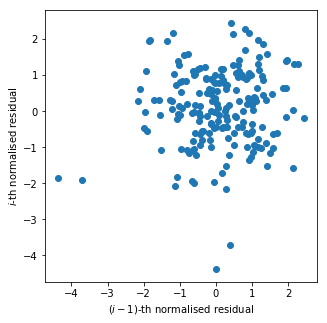

In [24]:
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_ylabel('$i$-th normalised residual')
ax.set_xlabel('$(i-1)$-th normalised residual')
plt.scatter(residuals[1:], [residuals[i - 1] for i in range(1, len(residuals))])

Apart from a few weird outliers, this looks pretty good: the majority of the points lie within $\pm 2$.